<a href="https://colab.research.google.com/github/GiovanniCar-99/Deep_Learning-NLP/blob/main/Codigo_Trabalho_Redes_Neurais_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as Bibliotecas

In [1]:
# Importando as principais bibliotecas python
import string
import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import time

# Importando as funções do Keras a fim de construir as arquiteturas de Deep Learning
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Flatten, GlobalAveragePooling1D, Reshape, Dropout, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.regularizers import l1,l2,l1_l2

# Importando outras bibliotecas para análise e pré-processamento
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

# Importando e Analisando as Bases (Emoções de Frases Simples)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Setando a seed em 42 para evitar aleatoriedade nos testes
np.random.seed(42)

In [4]:
teste = pd.read_csv('/content/drive/MyDrive/Docs/Emocoes_de_Texto/test.txt',sep=';',header=None,names=['Frases','Sentimento'])
treino = pd.read_csv('/content/drive/MyDrive/Docs/Emocoes_de_Texto/train.txt',sep=';',header=None,names=['Frases','Sentimento'])
validacao = pd.read_csv('/content/drive/MyDrive/Docs/Emocoes_de_Texto/val.txt',sep=';',header=None,names=['Frases','Sentimento'])

In [ ]:
print(f'O tamanho dos datasets são Treino: {treino.shape[0]} \n Teste: {teste.shape[0]} \n Validação {validacao.shape[0]}')

O tamanho dos datasets são Treino: 16000 
 Teste: 2000 
 Validação 2000


In [ ]:
dataset = pd.concat([teste,treino,validacao],ignore_index=True)
dataset.shape

(20000, 2)

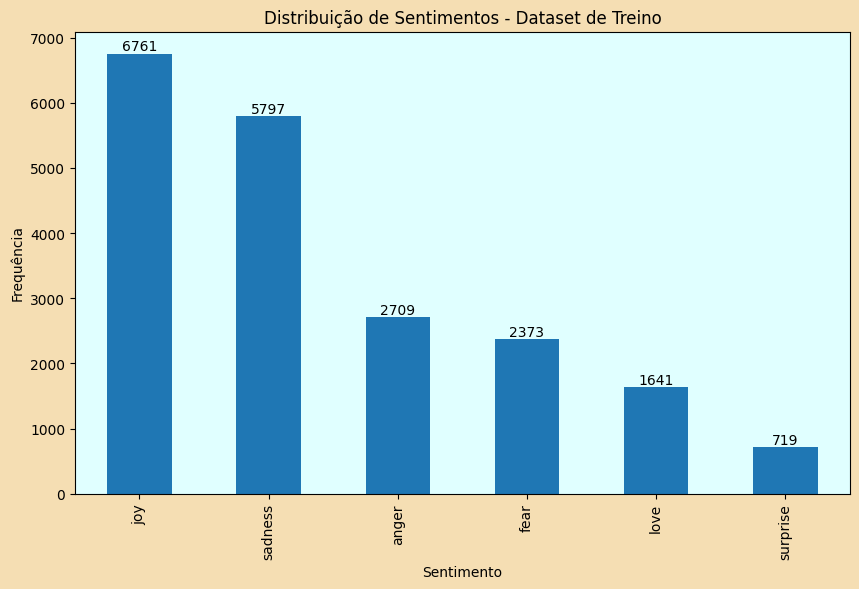

In [ ]:
# Plotando a representatividade dos sentimentos presentes no dataset
fig, ax = plt.subplots(figsize=(10, 6),facecolor='wheat')
dataset.Sentimento.value_counts().plot(kind='bar',ax=ax)
ax.set_facecolor('lightcyan')
ax.set_title('Distribuição de Sentimentos - Dataset de Treino')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Sentimento')
ax.set_ylabel('Frequência')
plt.show()

In [ ]:
# separando em frases e respostas
sentences = dataset.Frases.tolist()
# codificando os sentimentos
categorias_cod = pd.Categorical(dataset.Sentimento)
sentimentos = categorias_cod.codes

In [ ]:
dataset.Sentimento.value_counts(normalize=True)*100

,proportion
Sentimento,
joy,33.805
sadness,28.985
anger,13.545
fear,11.865
love,8.205
surprise,3.595


# Pre processamento dos dados

In [ ]:
# 2. Tokenização e preparação dos dados
# Aqui, vou criar um dicionário apenas levando em conta o teste, uma vez que no treino e validação temos palavras a mais (validar esse ponto)
tokenizer= Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index

In [ ]:
len(word_index)

17096

In [ ]:
max_length_global = max(len(seq) for seq in sequences)
# Padronizando as sequências
X = pad_sequences(sequences, maxlen=max_length_global)

In [ ]:
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          15,    7,  205,  714,   14,   15,   25,   45, 4770,  111,   58],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   15, 4771,   10,  234,   36,    1,    2,  455],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

# Treinando o Word2Vec

In [ ]:
# 3. Treinando o modelo Word2Vec
# Teremos uma janela de 5 palavras para obter o contexto de uma palavra
# min_count será considerado 1 para que o modelo treine com todas as palavras do vocabulario
# iremos testar primeiramente o Skip-Gram, uma vez que, queremos adicionar riqueza de detalhes ao vetor da palavra
w2v_model = Word2Vec(sentences=[s.split() for s in sentences], vector_size=100, window=5, min_count=1, sg=1)

In [ ]:
w2v_model.wv.vectors.shape

(17096, 100)

# Analisando o espaço vetorial criado pelo Word2Vec

## 1. Analisando as palavras próximas das palavras chaves

In [ ]:
# exemplos de frases de alegria
pd.set_option('display.max_colwidth', 1000)
dataset.loc[dataset['Sentimento'] == 'joy'].head(5)

,Frases,Sentimento
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy
7,i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia,joy
8,i like to have the same breathless feeling as a reader eager to see what will happen next,joy
13,i just feel extremely comfortable with the group of people that i dont even need to hide myself,joy
16,i feel a little mellow today,joy


In [ ]:
# Vamos entender as palavras que o Word2Vec colocaram próximas das palavras
# "optimistic", "excitement", "eager", "comfortable"
palavras_optimistic = w2v_model.wv.most_similar(positive=['optimistic'],topn = 3)
palavras_excitement = w2v_model.wv.most_similar(positive=['excitement'],topn = 3)
palavras_eager = w2v_model.wv.most_similar(positive=['eager'],topn = 3)
palavras_comfortable = w2v_model.wv.most_similar(positive=['comfortable'],topn = 3)
print('Palavras próximas de optimistic')
print(palavras_optimistic)
print('Palavras próximas de excitement')
print(palavras_excitement)
print('Palavras próximas de eager')
print(palavras_eager)
print('Palavras próximas de comfortable')
print(palavras_comfortable)

Palavras próximas de optimistic
[('hopeful', 0.9672988057136536), ('mellow', 0.9642111659049988), ('generally', 0.9498569369316101)]
Palavras próximas de excitement
[('connected', 0.9810889363288879), ('fellow', 0.9797782897949219), ('gratitude', 0.9793527126312256)]
Palavras próximas de eager
[('pressure', 0.9511246085166931), ('reluctant', 0.9504276514053345), ('frantic', 0.9475271701812744)]
Palavras próximas de comfortable
[('deeply', 0.9526925683021545), ('peaceful', 0.9464622139930725), ('supported', 0.9450891613960266)]


In [ ]:
# para frases de tristesa
dataset.loc[dataset['Sentimento'] == 'sadness'].head(5)

,Frases,Sentimento
0,im feeling rather rotten so im not very ambitious right now,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness
4,i was feeling a little vain when i did this one,sadness
11,i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey,sadness


In [ ]:
# Vamos utilizar as palavras "rotten", "shitty", "ashamed", "vain", "emotional"
palavras_rotten = w2v_model.wv.most_similar(positive = ['rotten'],topn = 3)
palavras_shitty = w2v_model.wv.most_similar(positive=['shitty'],topn = 3)
palavras_ashamed = w2v_model.wv.most_similar(positive=['ashamed'],topn = 3)
palavras_vain = w2v_model.wv.most_similar(positive=['vain'],topn = 3)
palavras_emotional = w2v_model.wv.most_similar(positive=['emotional'],topn = 3)
print('Palavras próximas de rotten')
print(palavras_rotten)
print('Palavras próximas de shitty')
print(palavras_shitty)
print('Palavras próximas de ashamed')
print(palavras_ashamed)
print('Palavras próximas de vain')
print(palavras_vain)
print('Palavras próximas de emotional')
print(palavras_emotional)

Palavras próximas de rotten
[('terrible', 0.9791292548179626), ('lousy', 0.9757198095321655), ('weepy', 0.9730850458145142)]
Palavras próximas de shitty
[('rotten', 0.9647818207740784), ('terrible', 0.9615828990936279), ('lousy', 0.9604200124740601)]
Palavras próximas de ashamed
[('jealous', 0.9628311395645142), ('envious', 0.9505292773246765), ('ugly', 0.9501702189445496)]
Palavras próximas de vain
[('suppose', 0.955217719078064), ('notice', 0.954969584941864), ('difference', 0.9501568675041199)]
Palavras próximas de emotional
[('unsuccessful', 0.9385616779327393), ('drama', 0.9381595849990845), ('inhibited', 0.9376263618469238)]


## Analisando o entendimento semântico e sintatico

In [ ]:
# Vamos entender as relações semânticas e sintaticas do modelo do word2vec
resultado = w2v_model.wv.most_similar(positive=[ 'human','friend'],topn=4)
print("Resultado da operação 'human + friend':\n", resultado)
resultado = w2v_model.wv.most_similar(positive=['scared','feeling'],topn=4)
print("Resultado da operação 'scared + feeling':\n", resultado)

Resultado da operação 'human + friend':
 [('teacher', 0.9528295993804932), ('gift', 0.9482722282409668), ('mom', 0.9444794654846191), ('wife', 0.9441970586776733)]
Resultado da operação 'scared + feeling':
 [('sick', 0.9306175708770752), ('confused', 0.9292648434638977), ('worried', 0.9221643805503845), ('sad', 0.9209733605384827)]


## Analisando visualmente

In [ ]:
# Escolher algumas palavras para plotar
# sample_words_padrao = random.sample(list(word_index_padrao.keys()), 10)
sample_words = random.sample(list(word_index.keys()), 20)

# Obter os vetores para as palavras escolhidas
vectors = [w2v_model.wv[word] for word in sample_words]

vectors = np.array(vectors)

# Reduzir a dimensionalidade para 2D
tsne = TSNE(n_components=3, random_state=42,perplexity=5)
tsne_results = tsne.fit_transform(vectors)

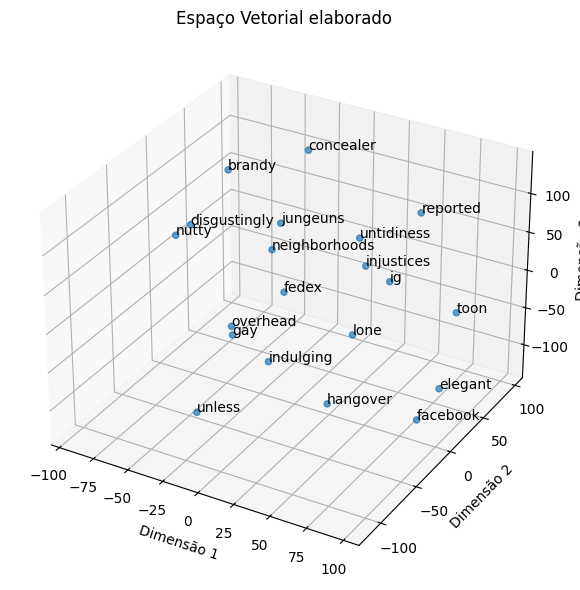

In [ ]:
# 4. Plotar os gráficos
fig = plt.figure(figsize=(14, 6))

# Gráfico para a camada de embedding
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], alpha=0.7)
for i, word in enumerate(sample_words):
    ax1.text(tsne_results[i, 0], tsne_results[i, 1], tsne_results[i, 2], word)
ax1.set_title('Espaço Vetorial elaborado')
ax1.set_xlabel('Dimensão 1')
ax1.set_ylabel('Dimensão 2')
ax1.set_zlabel('Dimensão 3')

plt.tight_layout()
plt.show()

## Conclusão

Podemos observar aqui que não temos essas relações complexas captadas para nossa corpora de texto, isso pode ocorrer pois está faltando o "contexto" da frase, sendo assim, vamos seguir com:
1. Arquiteturas com Embedding Próprio
2. Arquiteturas com Embedding pré-treinado


# Definindo os modelos de redes neurais

In [ ]:

# 4. Definindo hiperparâmetros
embedding_dim = 100
lstm_units = 32
epochs = 30


In [ ]:
# Obter os pesos do Word2Vec
embedding_matrix = w2v_model.wv.vectors

# Adicionar um vetor de zeros para o índice 0 (padding)
embedding_matrix = np.vstack([np.zeros((1, embedding_dim)), embedding_matrix])


In [ ]:
embedding_matrix.shape

(17097, 100)

In [ ]:
# 5. Função para construir os modelos
# Onde teremos:
# 1 - Uma rede com duas camadas densas de MLP apenas
# 2 - O mesmo que acima, porém adicionamos o Embedding
# 3 - Uma RNN com Skip-Gram
# 5 - Uma rede com duas camadas de GRU e Embedding Treinado
# 4 - Uma rede com duas camadas de LSTM e Embedding Treinado
# Em todas, iremos utilizar técnicas para evitar o overfit sendo: Dropout + Regularização lasso nas camadas densas para "selecionar" os principais features

def build_mlp_simple():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1 , output_dim=embedding_dim)(inputs) # camada de embedding dentro da prórpria rede
    flatten = Flatten()(embedding_layer) # transforma em um único vetor todo o espaço vetorial criado pelo embedding
    dense_out1 = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(flatten) #mesma arquitetura anterior
    dropout_layer = Dropout(0.3)(dense_out1) # Dropout para evitar overfitting
    dense_out2 = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(dropout_layer) # segunda camada com "Relu"
    dropout_layer2 = Dropout(0.3)(dense_out2) # Dropout para evitar overfitting
    outputs = Dense(6, activation='softmax')(dropout_layer2)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mlp_with_embedding():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)(inputs) # camada de Embedding com os pesos já iniciados pelo Skip-gram
    flatten = Flatten()(embedding_layer) # transforma em um único vetor todo o espaço vetorial criado pelo embedding
    dense_out1 = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(flatten) #mesma arquitetura anterior
    dropout_layer = Dropout(0.3)(dense_out1) # Dropout para evitar overfitting
    dense_out2 = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(dropout_layer) # segunda camada com "Relu"
    dropout_layer2 = Dropout(0.3)(dense_out2) # Dropout para evitar overfitting
    outputs = Dense(6, activation='softmax')(dropout_layer2)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_simple_RNN():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)(inputs) # camada de Embedding com os pesos já iniciados pelo Skip-Gram
    RNN1 = SimpleRNN(32, return_sequences=True, dropout=0.3)(embedding_layer) # camada com RNN para adicionarmos "memória" ao modelo
    RNN2 = SimpleRNN(32, dropout=0.3)(RNN1) # camada com RNN para adicionarmos "memória" ao modelo
    dense_out = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(RNN2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.3)(dense_out) # Dropout para evitar overfitting
    outputs = Dense(6, activation='softmax')(dropout_layer)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_simple_GRU():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)(inputs) # camada de Embedding com os pesos já iniciados pelo Skip-Gram
    GRU1 = GRU(32, return_sequences=True, dropout=0.3)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(32, dropout=0.3)(GRU1)
    dense_out = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.3)(dense_out) # Dropout para evitar overfitting
    outputs = Dense(6, activation='softmax')(dropout_layer)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def build_model_with_lstm():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)(inputs) # camada de Embedding com os pesos já iniciados pelo Skip-Gram
    lstm_out1 = LSTM(lstm_units,return_sequences=True, dropout= 0.3)(embedding_layer) # camada com LSTM para adicionarmos "memória" ao modelo
    lstm_out2 = LSTM(lstm_units,dropout=0.3)(lstm_out1) # camada com LSTM para adicionarmos "memória" ao modelo
    dense_out = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(lstm_out2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.3)(dense_out) # Dropout para evitar overfitting
    outputs = Dense(6, activation='softmax')(dropout_layer)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Instanciando e Treinando os modelos

Neles, vamos colocar sempre camadas de dropout e adicionar regularização Ridge para evitar o overfitting

In [ ]:

# 6. Instanciando os modelos
models = {
    "MLP Simples": build_mlp_simple(),
    "MLP com Embedding": build_mlp_with_embedding(),
    "RNN com Embedding" : build_simple_RNN(),
    "GRU com Embedding": build_simple_GRU(),
    "LSTM com Embedding": build_model_with_lstm()
}

In [ ]:
# entendendo a estrutura dos modelos
for name, model in models.items():
  print(f'Modelo {name} tem a estrutura:')
  print(model.summary())
  print('-----------------------------------')

Modelo MLP Simples tem a estrutura:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         422,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,134,442 (8.14 MB)

 Trainable params: 2,134,442 (8.14 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------
Modelo MLP com Embedding tem a estrutura:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         422,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,134,442 (8.14 MB)

 Trainable params: 2,134,442 (8.14 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------
Modelo RNN com Embedding tem a estrutura:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 66, 32)              │           4,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,717,290 (6.55 MB)

 Trainable params: 1,717,290 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------
Modelo GRU com Embedding tem a estrutura:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 66, 32)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,730,154 (6.60 MB)

 Trainable params: 1,730,154 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------
Modelo LSTM com Embedding tem a estrutura:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 66, 32)              │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,736,298 (6.62 MB)

 Trainable params: 1,736,298 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------


In [ ]:
# Dividir os dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, sentimentos, test_size=0.2, random_state=42)

In [ ]:
history_dict = {}
for name, model in models.items():
    print(f"Treinando o modelo: {name}")
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0,batch_size=264)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    history_dict[name] = {
        "loss": history.history['loss'],
        "accuracy": history.history['accuracy'],
        "test_loss": loss,
        "test_accuracy": accuracy
    }

Treinando o modelo: MLP Simples
Treinando o modelo: MLP com Embedding
Treinando o modelo: RNN com Embedding
Treinando o modelo: GRU com Embedding
Treinando o modelo: LSTM com Embedding


# Avaliando as métricas de erro

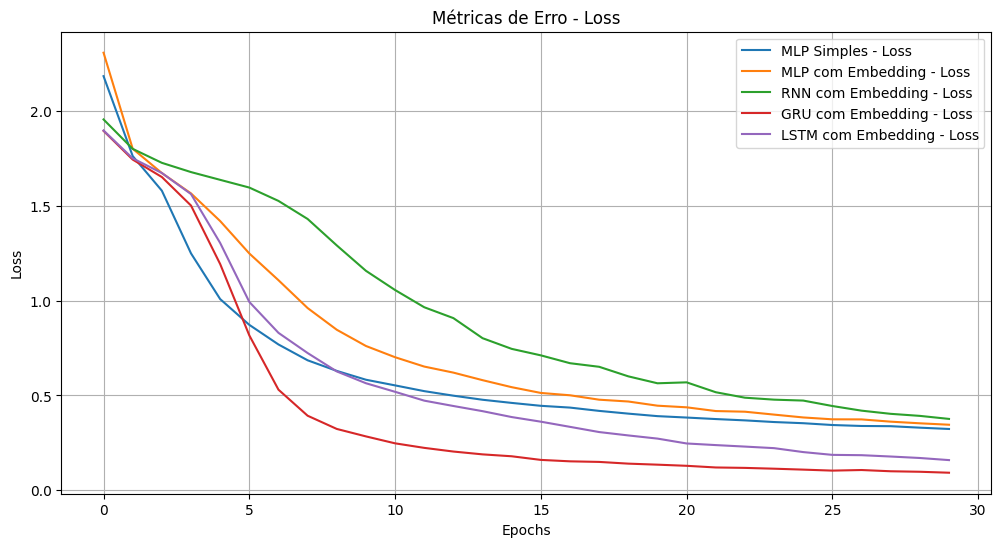

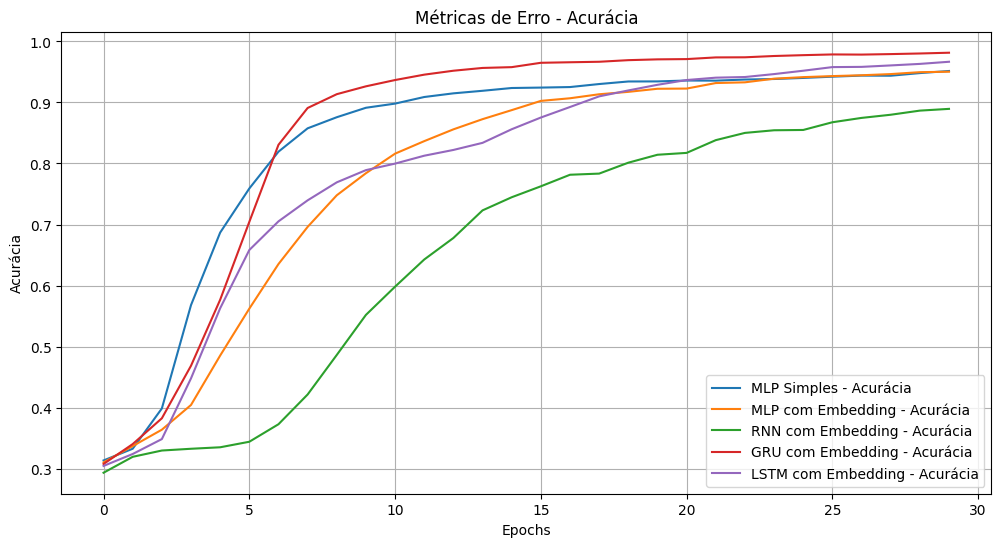

In [ ]:

# 7. Visualizando as métricas de erro
plt.figure(figsize=(12, 6))
for name, metrics in history_dict.items():
    plt.plot(metrics['loss'], label=f'{name} - Loss')
plt.title('Métricas de Erro - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
for name, metrics in history_dict.items():
    plt.plot(metrics['accuracy'], label=f'{name} - Acurácia')
plt.title('Métricas de Erro - Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()



In [ ]:
for name, metrics in history_dict.items():
    teste_acuracia = metrics['test_accuracy']
    print(f'Para teste temos, para o modelo {name} \nAcuracia: {teste_acuracia}')

Para teste temos, para o modelo MLP Simples 
Acuracia: 0.7707499861717224
Para teste temos, para o modelo MLP com Embedding 
Acuracia: 0.7677500247955322
Para teste temos, para o modelo RNN com Embedding 
Acuracia: 0.7944999933242798
Para teste temos, para o modelo GRU com Embedding 
Acuracia: 0.9017500281333923
Para teste temos, para o modelo LSTM com Embedding 
Acuracia: 0.8832499980926514


Podemos observar que as arquiteturas que pressupõe que existam uma dependencia temporal entre os tokens são melhores tanto na acurácia quanto na convergencia dos modelos. Podemos ver que a escalada de complexidade entre LSTMs e GRU não trás benefícios.

Podemos perceber uma outra interação interessante, entre a MLP com Embedding próprio e a RNN com Embedding pré treinado. Podemos perceber que, mesmo com a "dependencia temoporal" a rede com RNN foi superada pela simples MLP, indicando que o Embedding pode ter beneficios.

Vamos, assim, testar a arquitetura "vencedora" com e sem o Embedding do Word2Vec

Sendo assim, o próximo passo é medir o impacto do Embedding no treinamento, e as próximas arquiteturas a serem criadas são:
- GRU com Embedding da Rede
- GRU pré-treinado
- GRU pré-treinado sem treinar (ganho em tempo de treinamento e processamento)

Ambas terão as camadas de dropout e regularização Ridge para evitar ao máximo o overffiting

In [ ]:
def GRU_Embedding_Proprio():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1 , output_dim=embedding_dim)(inputs)
    GRU1 = GRU(32, return_sequences=True, dropout=0.3)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(32, dropout=0.3)(GRU1)
    dense_out = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.3)(dense_out)
    outputs = Dense(6, activation='softmax')(dropout_layer)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def GRU_Embedding_W2V():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)(inputs) # camada de Embdedding do Word2Vec
    GRU1 = GRU(32, return_sequences=True, dropout=0.3)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(32, dropout=0.3)(GRU1)
    dense_out = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.3)(dense_out)
    outputs = Dense(6, activation='softmax')(dropout_layer)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def GRU_Embedding_W2V_Nao_Treinado():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(inputs) # camada de Embdedding do Word2Vec
    GRU1 = GRU(32, return_sequences=True, dropout=0.3)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(32, dropout=0.3)(GRU1)
    dense_out = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.3)(dense_out)
    outputs = Dense(6, activation='softmax')(dropout_layer)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# 6. Instanciando os modelos
modelos_vencedores = {
    "GRU Embedding Simples": GRU_Embedding_Proprio(),
    "GRU Embedding Word2Vec": GRU_Embedding_W2V(),
    "GRU Embedding Word2Vec Não Treinado": GRU_Embedding_W2V_Nao_Treinado()
}

In [ ]:
# entendendo a estrutura dos modelos
for name, model in modelos_vencedores.items():
  print(f'Modelo {name} tem a estrutura:')
  print(model.summary())
  print('-----------------------------------')

Modelo GRU Embedding Simples tem a estrutura:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 66, 32)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,730,154 (6.60 MB)

 Trainable params: 1,730,154 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------
Modelo GRU Embedding Word2Vec tem a estrutura:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 66, 32)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,730,154 (6.60 MB)

 Trainable params: 1,730,154 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

None
-----------------------------------
Modelo GRU Embedding Word2Vec Não Treinado tem a estrutura:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 66, 32)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,730,154 (6.60 MB)

 Trainable params: 20,454 (79.90 KB)

 Non-trainable params: 1,709,700 (6.52 MB)

None
-----------------------------------


In [ ]:
history_vencedor = {}
for name, model in modelos_vencedores.items():
    print(f"Treinando o modelo: {name}")
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0,batch_size=128)
    end_time = time.time()
    training_time = end_time - start_time
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    history_vencedor[name] = {
        "loss": history.history['loss'],
        "accuracy": history.history['accuracy'],
        "test_loss": loss,
        "test_accuracy": accuracy
    }
    print(f"Tempo de treinamento do modelo {name}: {training_time:.2f} segundos")


Treinando o modelo: GRU Embedding Simples
Tempo de treinamento do modelo GRU Embedding Simples: 42.36 segundos
Treinando o modelo: GRU Embedding Word2Vec
Tempo de treinamento do modelo GRU Embedding Word2Vec: 42.58 segundos
Treinando o modelo: GRU Embedding Word2Vec Não Treinado
Tempo de treinamento do modelo GRU Embedding Word2Vec Não Treinado: 51.48 segundos


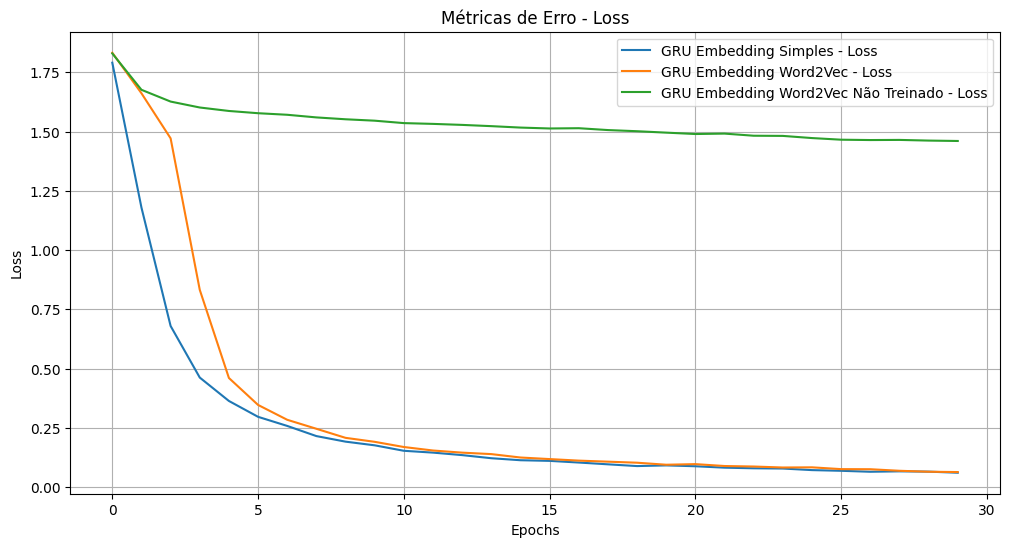

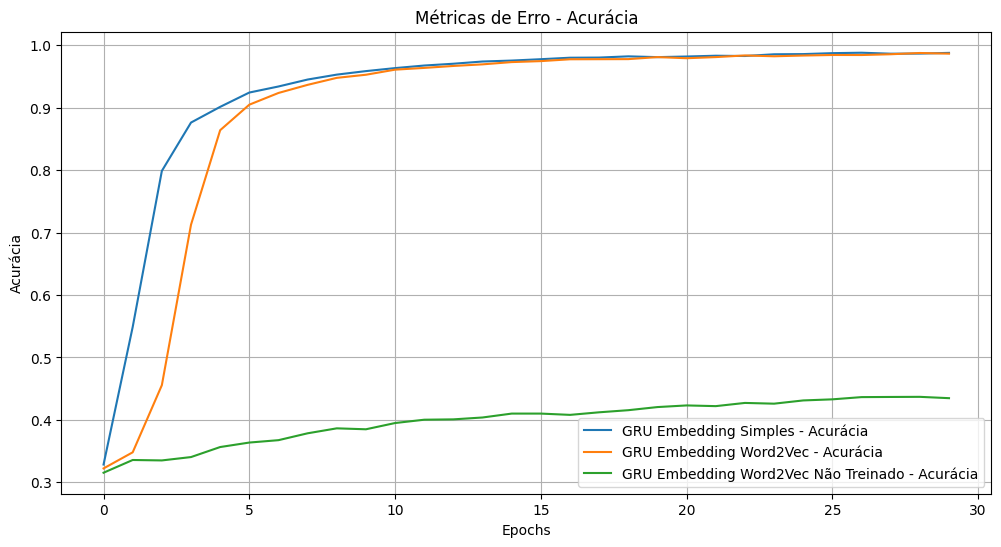

In [ ]:
# 7. Visualizando as métricas de erro
plt.figure(figsize=(12, 6))
for name, metrics in history_vencedor.items():
    plt.plot(metrics['loss'], label=f'{name} - Loss')
plt.title('Métricas de Erro - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
for name, metrics in history_vencedor.items():
    plt.plot(metrics['accuracy'], label=f'{name} - Acurácia')
plt.title('Métricas de Erro - Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()


In [ ]:
for name, metrics in history_vencedor.items():
    teste_acuracia = metrics['test_accuracy']
    print(f'Para teste temos, para o modelo {name} \nAcuracia: {teste_acuracia}')

Para teste temos, para o modelo GRU Embedding Simples 
Acuracia: 0.8952500224113464
Para teste temos, para o modelo GRU Embedding Word2Vec 
Acuracia: 0.9104999899864197
Para teste temos, para o modelo GRU Embedding Word2Vec Não Treinado 
Acuracia: 0.42925000190734863


Podemos perceber que, mesmo convergindo para uma boa acurácia, o Embedding simples da própria rede teve um melhor resultado do que o treinado com o Word2Vec.

Isso é explicado por conta de dois fatores:
- Corpora Pequena para criar Embeddings robustos apenas com as frases (aqui temos menos de 20 mil palavras, sendo que os Embeddings mais clássicos apresentados em artigos levam em conta bilhões de palavras, ou até a corpora inteira de uma lingua)
- Sem a análise de contexto. Levando em conta o que foi discutido acima, uma vez que temos um Embedding que não é capaz de captar bem as nuances das palavras, ao inicializar com esses pesos, podemos observar que demoramos mais para convergir, ou seja, utilizar arquiteturas mais direcionadas é uma vantagem


Vamos entender a diferença entre o embedding do modelo mais eficaz x word2vec (skip-gram)

In [ ]:
# 1. Pegar 50 palavras aleatórias
# Suponha que você tenha um dicionário de palavras

sample_words = random.sample(list(word_index.keys()), 30)

# 2. Obter os vetores de embedding e Word2Vec
# Obtendo os vetores da camada de embedding do modelo Keras
embedding_layer = modelos_vencedores["GRU Embedding Simples"].get_layer('embedding_5')
embedding_weights = embedding_layer.get_weights()[0]

embedding_vectors = []
word2vec_vectors = []

# Carregar o modelo Word2Vec


for word in sample_words:
    # Vetor da camada de embedding
    index = word_index[word]
    embedding_vectors.append(embedding_weights[index])

    # Vetor do Word2Vec
    if word in w2v_model.wv:
        word2vec_vectors.append(w2v_model.wv[word])
    else:
        word2vec_vectors.append(np.zeros(embedding_weights.shape[1]))  # Vetor nulo para palavras não encontradas

embedding_vectors = np.array(embedding_vectors)
word2vec_vectors = np.array(word2vec_vectors)

# 3. Reduzir dimensionalidade para 3 dimensões usando t-SNE
tsne = TSNE(n_components=3, random_state=42,perplexity=5)

embedding_reduced = tsne.fit_transform(embedding_vectors)
word2vec_reduced = tsne.fit_transform(word2vec_vectors)


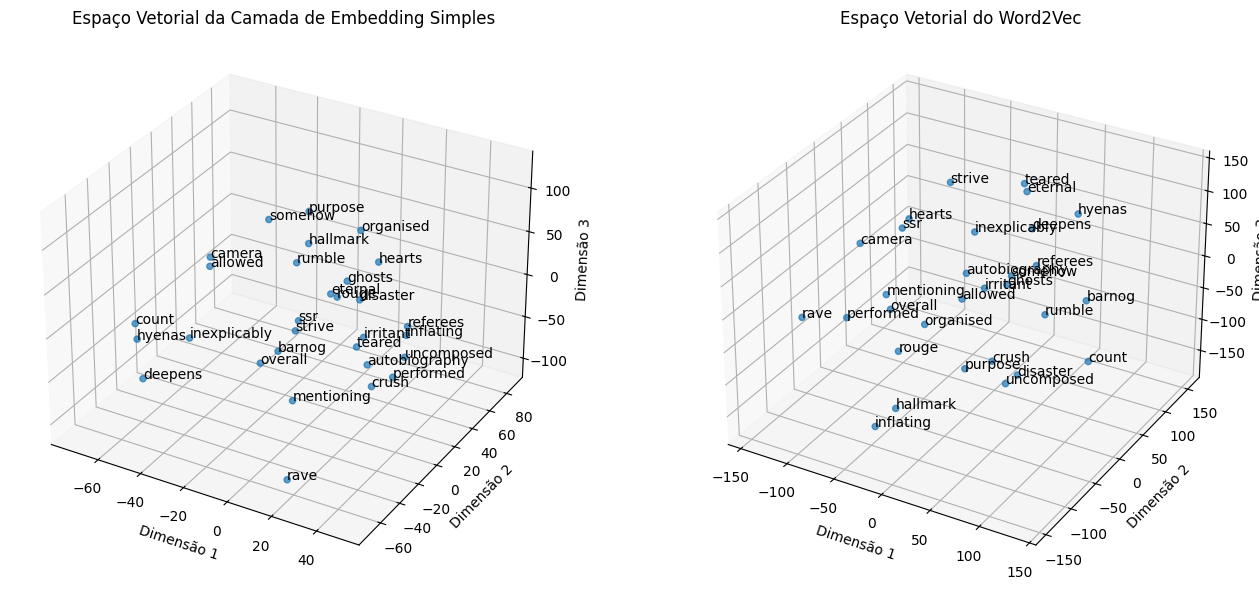

In [ ]:

# 4. Plotar os gráficos
fig = plt.figure(figsize=(14, 6))

# Gráfico para a camada de embedding
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(embedding_reduced[:, 0], embedding_reduced[:, 1], embedding_reduced[:, 2], alpha=0.7)
for i, word in enumerate(sample_words):
    ax1.text(embedding_reduced[i, 0], embedding_reduced[i, 1], embedding_reduced[i, 2], word)
ax1.set_title('Espaço Vetorial da Camada de Embedding Simples')
ax1.set_xlabel('Dimensão 1')
ax1.set_ylabel('Dimensão 2')
ax1.set_zlabel('Dimensão 3')

# Gráfico para o Word2Vec
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(word2vec_reduced[:, 0], word2vec_reduced[:, 1], word2vec_reduced[:, 2], alpha=0.7)
for i, word in enumerate(sample_words):
    ax2.text(word2vec_reduced[i, 0], word2vec_reduced[i, 1], word2vec_reduced[i, 2], word)
ax2.set_title('Espaço Vetorial do Word2Vec')
ax2.set_xlabel('Dimensão 1')
ax2.set_ylabel('Dimensão 2')
ax2.set_zlabel('Dimensão 3')

plt.tight_layout()
plt.show()

In [ ]:
# Invertendo o word_index para obter um dicionário de índice para palavra
index_to_word = {index: word for word, index in tokenizer.word_index.items()}


def palavras_similares(embedding_weights, palavra, word_index, index_to_word, topn=3):
    # Verifica se a palavra está no vocabulário
    if palavra not in word_index:
        print(f"A palavra '{palavra}' não está no vocabulário.")
        return []

    # Obtém o índice e vetor da palavra
    idx = word_index[palavra]
    palavra_vector = embedding_weights[idx].reshape(1, -1)

    # Calcula a similaridade de cosseno entre a palavra e todos os outros vetores
    similaridades = cosine_similarity(palavra_vector, embedding_weights)[0]

    # Seleciona os índices dos vetores mais similares
    similar_indices = np.argsort(similaridades)[::-1][1:topn + 1]

    # Retorna as palavras similares
    palavras_similares = [index_to_word[i] for i in similar_indices]
    return palavras_similares


In [ ]:
print('Palavras próximas de optimistic')
print("Palavras similares:", palavras_similares(embedding_weights, "optimistic", tokenizer.word_index, index_to_word))
print('Palavras próximas de excitement')
print("Palavras similares:", palavras_similares(embedding_weights, "excitement", tokenizer.word_index, index_to_word))
print('Palavras próximas de eager')
print("Palavras similares:", palavras_similares(embedding_weights, "eager", tokenizer.word_index, index_to_word))
print('Palavras próximas de comfortable')
print("Palavras similares:", palavras_similares(embedding_weights, "comfortable", tokenizer.word_index, index_to_word))

Palavras próximas de optimistic
Palavras similares: ['rich', 'lively', 'elegant']
Palavras próximas de excitement
Palavras similares: ['melancholy', 'cheer', 'chose']
Palavras próximas de eager
Palavras similares: ['artistic', 'superior', 'mellow']
Palavras próximas de comfortable
Palavras similares: ['thankful', 'confident', 'joyful']


In [ ]:
def Modelo_Contexto_Final():
    inputs = Input(shape=(max_length_global,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index) +1 , output_dim=embedding_dim)(inputs)
    GRU1 = GRU(128, return_sequences=True, dropout=0.2)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(128, dropout=0.2)(GRU1)
    dense_out = Dense(64, activation='relu')(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.2)(dense_out)
    dense_out2 = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(dropout_layer) # segunda camada com "Relu"
    dropout_layer2 = Dropout(0.2)(dense_out2)
    outputs = Dense(6, activation='softmax')(dropout_layer2)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
modelo_final = Modelo_Contexto_Final()

In [ ]:
print(modelo_final.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 66, 100)             │       1,709,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 66, 128)             │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,907,626 (7.28 MB)

 Trainable params: 1,907,626 (7.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history_final ={}
print(f"Treinando o modelo vencedor")
start_time = time.time()
history = modelo_final.fit(X_train, y_train, epochs=30, verbose=0,batch_size=32)
end_time = time.time()
training_time = end_time - start_time
loss, accuracy = modelo_final.evaluate(X_test, y_test, verbose=0)
history_final['Modelo Final'] = {
    "loss": history.history['loss'],
    "accuracy": history.history['accuracy'],
    "test_loss": loss,
    "test_accuracy": accuracy
}
print(f"Tempo de treinamento do modelo final: {training_time:.2f} segundos")

Treinando o modelo vencedor
Tempo de treinamento do modelo final: 225.95 segundos


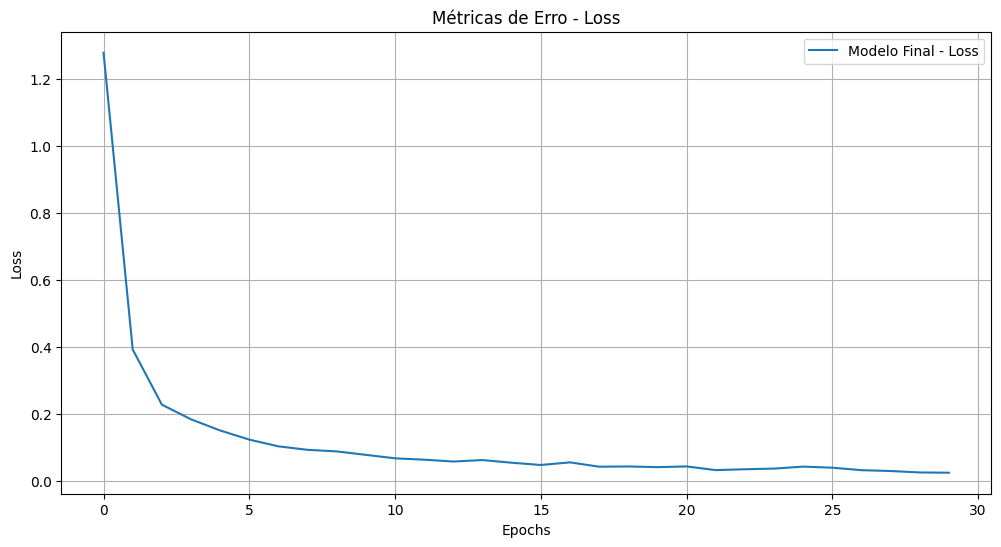

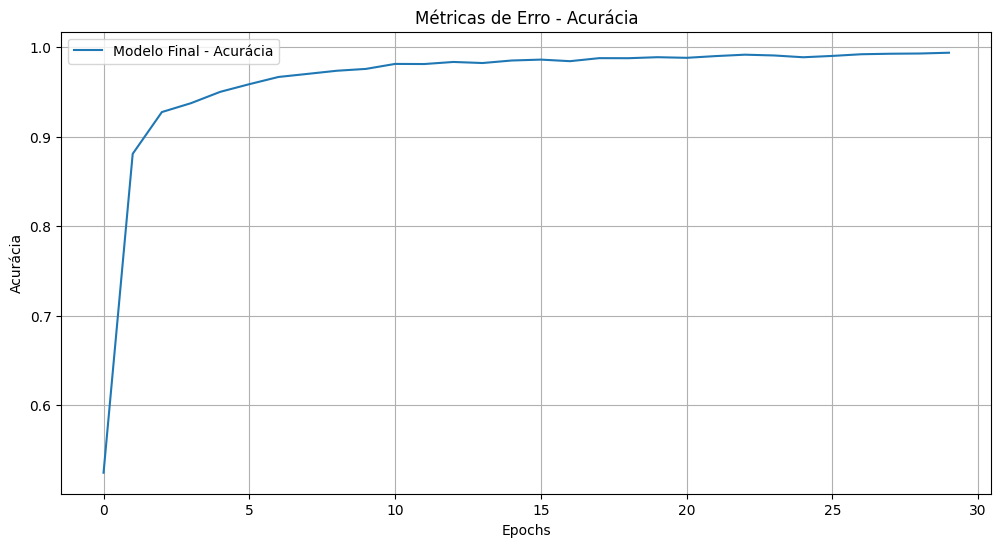

In [ ]:
# 7. Visualizando as métricas de erro
plt.figure(figsize=(12, 6))
for name, metrics in history_final.items():
    plt.plot(metrics['loss'], label=f'{name} - Loss')
plt.title('Métricas de Erro - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
for name, metrics in history_final.items():
    plt.plot(metrics['accuracy'], label=f'{name} - Acurácia')
plt.title('Métricas de Erro - Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()

In [ ]:
for name, metrics in history_final.items():
    teste_acuracia = metrics['test_accuracy']
    print(f'Para teste temos, para o modelo {name} \nAcuracia: {teste_acuracia}')

Para teste temos, para o modelo Modelo Final 
Acuracia: 0.9237499833106995


A fazer: Aplicar essa arquitetura no dataset do IMDB

In [ ]:
# Importando a base do IMDB
dados_imdb = pd.read_csv('/content/drive/MyDrive/Docs/IMDB_REVIEWS/IMDB Dataset.csv')



In [ ]:
dados_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Separando entre X e Y
X_imdb = dados_imdb['review']
y_imdb = dados_imdb['sentiment']

In [ ]:
# Transformando os sentimentos em 0: Negativo e 1: Positivo
y_imdb = y_imdb.map({'positive': 1, 'negative': 0})

In [ ]:
# Tokenizando as reviews
tokenizer_imdb = Tokenizer()
tokenizer_imdb.fit_on_texts(X_imdb)
X_imdb_tokenizado = tokenizer_imdb.texts_to_sequences(X_imdb)
word_index_imdb = tokenizer_imdb.word_index

In [ ]:
len(word_index_imdb)

124252

In [ ]:
max_length_imdb = max(len(seq) for seq in X_imdb_tokenizado)
# Fazendo o padding
X_imdb_pad = pad_sequences(X_imdb_tokenizado, maxlen=max_length_imdb, padding='post')

In [ ]:
max_length_imdb

2493

Podemos perceber que este dataset apresenta frases e estruturas muito mais complexas. Vamos ver como nossa arquitetura se comporta

In [ ]:
def Modelo_Contexto_Final_IMDB():
    inputs = Input(shape=(max_length_imdb,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index_imdb) +1 , output_dim=100)(inputs)
    GRU1 = GRU(128, return_sequences=True, dropout=0.2)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(128, dropout=0.2)(GRU1)
    dense_out = Dense(64, activation='relu')(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.2)(dense_out)
    dense_out2 = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(dropout_layer) # segunda camada com "Relu"
    dropout_layer2 = Dropout(0.2)(dense_out2)
    outputs = Dense(2, activation='sigmoid')(dropout_layer2)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Aplicando a arquitetura de contexto final neste nosso novo dataset
modelo_final_imdb = Modelo_Contexto_Final_IMDB()


In [ ]:
print(modelo_final_imdb.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2493)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 2493, 100)           │      12,425,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 2493, 128)           │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,623,094 (48.15 MB)

 Trainable params: 12,623,094 (48.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Dividindo o dataset do IMDB em treino e teste
X_imdb_train, X_imdb_test, y_imdb_train, y_imdb_test = train_test_split(X_imdb_pad, y_imdb, test_size=0.5, random_state=42)

In [ ]:
X_imdb_train.shape

(25000, 2493)

In [ ]:
X_imdb_pad.shape

(50000, 2493)

In [ ]:
history_final_imdb ={}
print(f"Treinando o modelo vencedor")
start_time = time.time()
history = modelo_final_imdb.fit(X_imdb_train, y_imdb_train, epochs=10, verbose=0,batch_size=128)
end_time = time.time()
training_time = end_time - start_time
loss, accuracy = modelo_final_imdb.evaluate(
    X_imdb_test, y_imdb_test,
    verbose=0
)
history_final_imdb['Modelo Final'] = {
    "loss": history.history['loss'],
    "accuracy": history.history['accuracy'],
    "test_loss": loss,
    "test_accuracy": accuracy
}
print(f"Tempo de treinamento do modelo final no IMDB: {training_time:.2f} segundos")


Treinando o modelo vencedor
Tempo de treinamento do modelo final no IMDB: 739.91 segundos


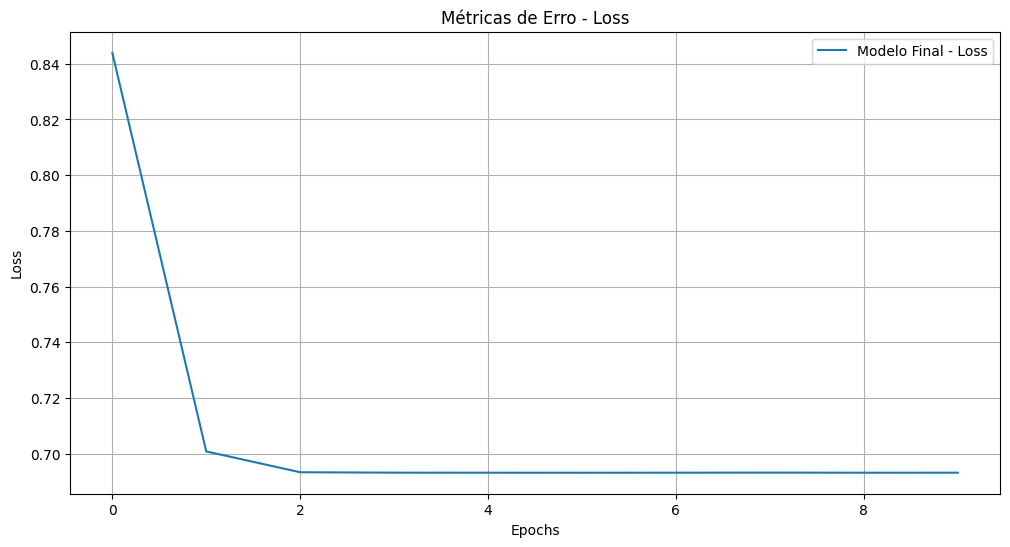

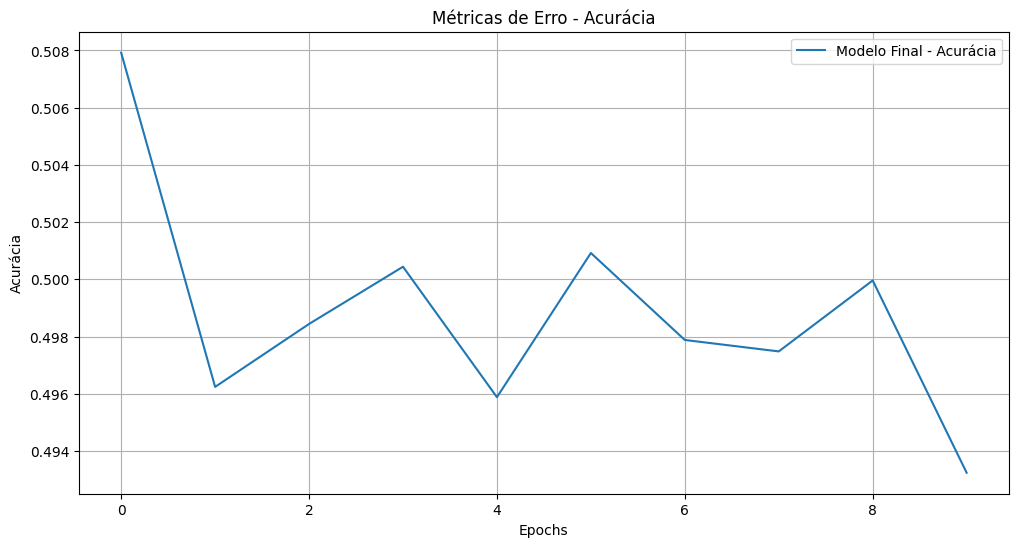

In [ ]:
# 7. Visualizando as métricas de erro
plt.figure(figsize=(12, 6))
for name, metrics in history_final_imdb.items():
    plt.plot(metrics['loss'], label=f'{name} - Loss')
plt.title('Métricas de Erro - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
for name, metrics in history_final_imdb.items():
    plt.plot(metrics['accuracy'], label=f'{name} - Acurácia')
plt.title('Métricas de Erro - Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()

In [ ]:
for name, metrics in history_final_imdb.items():
    teste_acuracia = metrics['test_accuracy']
    print(f'Para teste temos, para o modelo {name} \nAcuracia: {teste_acuracia}')

Para teste temos, para o modelo Modelo Final 
Acuracia: 0.49932000041007996


Realizando o teste com o tratamento NLTK, por conta do volume maior de palavras

In [ ]:
# Importando NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Inicializando o lematizador e stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Função de pré-processamento de texto
def preprocessar_frase(frase):
    # Converter para minúsculas
    frase = frase.lower()

    # Remover pontuação
    frase = ''.join([char for char in frase if char not in string.punctuation])

    # Tokenizar a frase (dividir em palavras)
    palavras = nltk.word_tokenize(frase)

    # Remover stopwords
    palavras_processadas = [palavra for palavra in palavras if palavra not in stop_words]

    return palavras_processadas

In [ ]:
X_imdb_processado = X_imdb.apply(preprocessar_frase)

In [ ]:
print(X_imdb_processado.head())  # Exemplo de frases processadas

0    [one, reviewers, mentioned, watching, 1, oz, e...
1    [wonderful, little, production, br, br, filmin...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, theres, family, little, boy, jake,...
4    [petter, matteis, love, time, money, visually,...
Name: review, dtype: object


In [ ]:
# Tokenizando agora as frases processadas
tokenizer_imdb_processado = Tokenizer()
tokenizer_imdb_processado.fit_on_texts(X_imdb_processado)
X_imdb_tokenizado_processado = tokenizer_imdb_processado.texts_to_sequences(X_imdb_processado)
word_index_imdb_processado = tokenizer_imdb_processado.word_index

In [ ]:
len(word_index_imdb_processado)

181259

In [ ]:
max_length_imdb_processado = max(len(seq) for seq in X_imdb_tokenizado_processado)
# Fazendo o padding
X_imdb_pad_processado = pad_sequences(X_imdb_tokenizado_processado, maxlen=max_length_imdb_processado, padding='post')

In [ ]:
max_length_imdb_processado

1449

In [ ]:
X_imdb_train_processado, X_imdb_test_processado, y_imdb_train_processado, y_imdb_test_processado = train_test_split(X_imdb_pad_processado, y_imdb, test_size=0.5, random_state=42)

In [ ]:
def Modelo_Contexto_Final_IMDB_Tratado():
    inputs = Input(shape=(max_length_imdb_processado,)) # camada de entrada que recebe os tokens (palavras)
    embedding_layer = Embedding(input_dim=len(word_index_imdb_processado) +1 , output_dim=100)(inputs)
    GRU1 = GRU(128, return_sequences=True)(embedding_layer) # camada com GRU para adicionarmos "memória" ao modelo
    GRU2 = GRU(128)(GRU1)
    dense_out = Dense(64, activation='relu')(GRU2) # segunda camada com "Relu"
    dropout_layer = Dropout(0.2)(dense_out)
    dense_out2 = Dense(32, activation='relu')(dropout_layer) # segunda camada com "Relu"
    dropout_layer2 = Dropout(0.2)(dense_out2)
    outputs = Dense(1, activation='sigmoid')(dropout_layer2)  # camada de output com softmax
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
modelo_final_imdb_tratado = Modelo_Contexto_Final_IMDB_Tratado()

In [ ]:
print(modelo_final_imdb_tratado.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1449)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 1449, 100)           │      18,126,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 1449, 128)           │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,323,761 (69.90 MB)

 Trainable params: 18,323,761 (69.90 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history_final_imdb_tratado ={}
print(f"Treinando o modelo vencedor")
start_time = time.time()
history = modelo_final_imdb_tratado.fit(X_imdb_train_processado, y_imdb_train_processado, epochs=50, verbose=0,batch_size=264)
end_time = time.time()
training_time = end_time - start_time
loss, accuracy = modelo_final_imdb_tratado.evaluate(
    X_imdb_test_processado, y_imdb_test_processado,
    verbose=0
)
history_final_imdb_tratado['Modelo Final'] = {
    "loss": history.history['loss'],
    "accuracy": history.history['accuracy'],
    "test_loss": loss,
    "test_accuracy": accuracy
}
print(f"Tempo de treinamento do modelo final no IMDB: {training_time:.2f} segundos")

Treinando o modelo vencedor
Tempo de treinamento do modelo final no IMDB: 1966.94 segundos


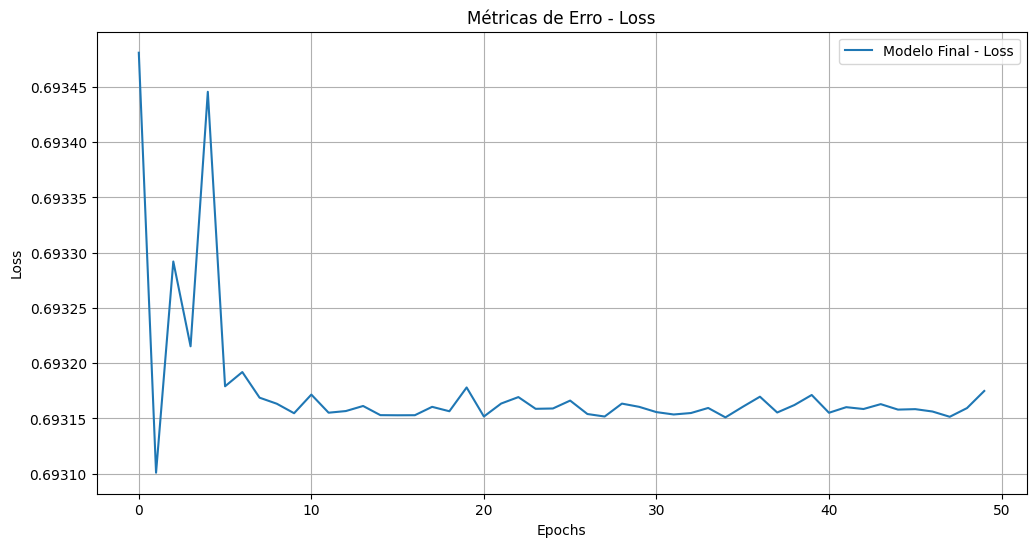

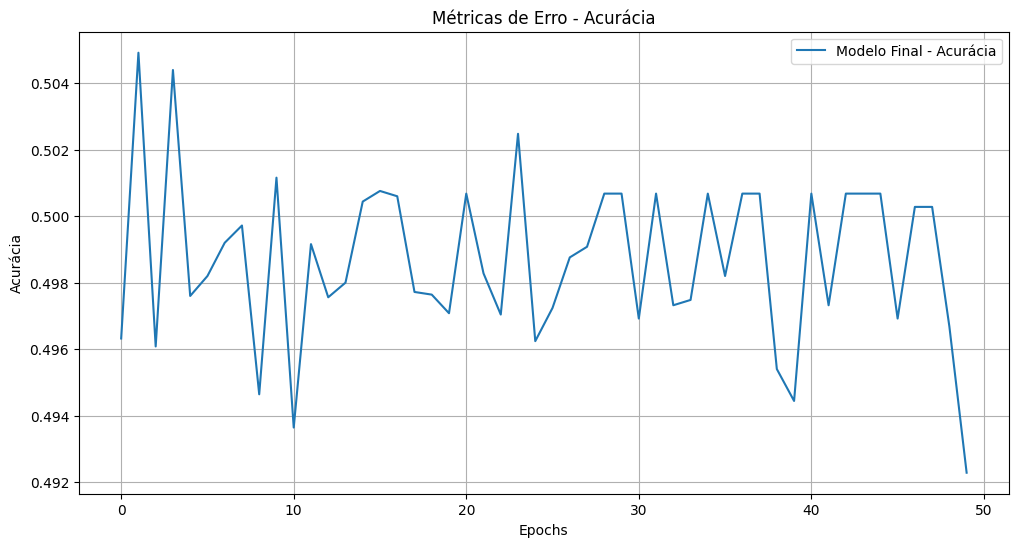

In [ ]:
# 7. Visualizando as métricas de erro
plt.figure(figsize=(12, 6))
for name, metrics in history_final_imdb_tratado.items():
    plt.plot(metrics['loss'], label=f'{name} - Loss')
plt.title('Métricas de Erro - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
for name, metrics in history_final_imdb_tratado.items():
    plt.plot(metrics['accuracy'], label=f'{name} - Acurácia')
plt.title('Métricas de Erro - Acurácia')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()

In [ ]:
for name, metrics in history_final_imdb_tratado.items():
    teste_acuracia = metrics['test_accuracy']
    print(f'Para teste temos, para o modelo {name} \nAcuracia: {teste_acuracia}')

Para teste temos, para o modelo Modelo Final 
Acuracia: 0.49932000041007996
